In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score, confusion_matrix, 
    log_loss, matthews_corrcoef
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
from collections import Counter

warnings.filterwarnings('ignore')

IMPORTO IL DATASET

In [2]:
data_path = "C:\\Users\\ludov\\OneDrive\\Desktop\\pokemons.csv"
df = pd.read_csv(data_path)

ISPEZIONO IL DATASET

In [3]:
print('ultime 5 righe','\n')
df.tail()

ultime 5 righe 



,id,name,rank,generation,evolves_from,type1,type2,hp,atk,def,spatk,spdef,speed,total,height,weight,abilities,desc
1012,1013,sinistcha,ordinary,generation-ix,poltchageist,grass,ghost,71,60,106,121,80,70,508,2,22,hospitality heatproof,Not Available
1013,1014,okidogi,legendary,generation-ix,nothing,poison,fighting,88,128,115,58,86,80,555,18,922,toxic-chain zero-to-hero,Not Available
1014,1015,munkidori,legendary,generation-ix,nothing,poison,psychic,88,75,66,130,90,106,555,10,122,toxic-chain frisk,Not Available
1015,1016,fezandipiti,legendary,generation-ix,nothing,poison,fairy,88,91,82,70,125,99,555,14,301,toxic-chain technician,Not Available
1016,1017,ogerpon,legendary,generation-ix,nothing,grass,None,80,120,84,60,96,110,550,12,398,defiant,Not Available


GESTISCO I MISSING VALUES

In [4]:
# Identifichiamo i missing values
print("Missing values per colonna:")
print(df.isnull().sum())


# Imputazione con la moda (per dati categorici o discreti)
for column in df.columns:  # Itera nuovamente su tutte le colonne del DataFrame
    # Controlla se il tipo di dati della colonna è 'object', tipicamente indicativo di dati categorici o di testo
    if df[column].dtype == 'object':
        # Imputa i valori mancanti nella colonna corrente con la moda della colonna
        # 'mode()[0]' è usato per selezionare il valore più frequente (la moda)
        # 'inplace=True' fa sì che la modifica sia applicata direttamente al DataFrame originale
        df[column].fillna(df[column].mode()[0], inplace=True)


# Verifica dopo l'imputazione
print("Verifica dopo l'imputazione dei missing values:")
print(df.isnull().sum())

Missing values per colonna:
id              0
name            0
rank            0
generation      0
evolves_from    0
type1           0
type2           0
hp              0
atk             0
def             0
spatk           0
spdef           0
speed           0
total           0
height          0
weight          0
abilities       0
desc            0
dtype: int64
Verifica dopo l'imputazione dei missing values:
id              0
name            0
rank            0
generation      0
evolves_from    0
type1           0
type2           0
hp              0
atk             0
def             0
spatk           0
spdef           0
speed           0
total           0
height          0
weight          0
abilities       0
desc            0
dtype: int64


GESTISCO GLI OUTLIERS

<font size="+1" face="Lato"><em> Calcolo della media e della deviazione standard per identificare gli outlier: </em></font>


In [5]:
# Definiamo una soglia k per identificare gli outlier basandoci su 3 deviazioni standard dalla media
k = 3

# Iteriamo sulle colonne numeriche per calcolare media e deviazione standard e per identificare gli outlier
for feature in ['hp', 'atk', 'def', 'spatk', 'spdef', 'speed', 'total', 'height', 'weight']:
    # Calcoliamo la media e la deviazione standard per la colonna corrente
    mean_value = df[feature].mean()
    std_dev = df[feature].std()
    
    # Identifichiamo gli outlier e aggiungiamo una nuova colonna per marcarli
    df['outlier_' + feature] = (df[feature] < (mean_value - k * std_dev)) | (df[feature] > (mean_value + k * std_dev))

# Riprendiamo il codice precedentemente eseguito per marcare gli outlier
# e identifichiamo le righe che contengono outlier.

# Per ogni feature numerica, selezioniamo le righe con outlier e li visualizziamo
outlier_rows = df[df.filter(like='outlier_').any(axis=1)] #.any(axis=1) verifica se, in qualsiasi colonna -->
# di una riga (perché axis=1 indica l'asse orizzontale, ovvero le colonne), c'è almeno un valore True.-->
# Se c'è almeno un True in una riga, .any(axis=1) restituisce True per quella riga; altrimenti, restituisce False.

# Visualizziamo le righe che hanno almeno un outlier in una delle colonne numeriche
outlier_rows[['name'] + [col for col in df.columns if 'outlier_' in col]] # itera attraverso tutte le colonne di 'pokemons_df'
# e seleziona solo quelle colonne il cui nome contiene 'outlier_', indicando che sono colonne utilizzate per segnalare outlier.


,name,outlier_hp,outlier_atk,outlier_def,outlier_spatk,outlier_spdef,outlier_speed,outlier_total,outlier_height,outlier_weight
90,cloyster,False,False,True,False,False,False,False,False,False
94,onix,False,False,True,False,False,False,False,True,False
112,chansey,True,False,False,False,False,False,False,False,False
129,gyarados,False,False,False,False,False,False,False,True,False
142,snorlax,True,False,False,False,False,False,False,False,True
201,wobbuffet,True,False,False,False,False,False,False,False,False
207,steelix,False,False,True,False,False,False,False,True,False
212,shuckle,False,False,True,False,True,False,False,False,False
241,blissey,True,False,False,False,False,False,False,False,False
248,lugia,False,False,False,False,True,False,False,True,False


10 MIGLIORI POKEMON

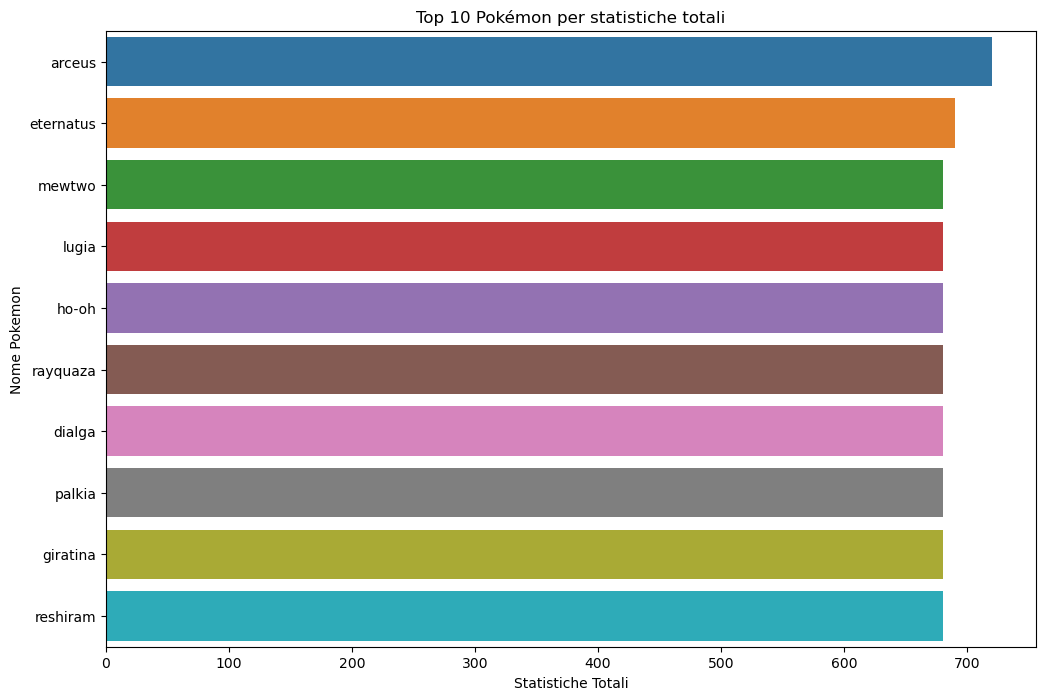

In [6]:
# Selezione dei top 10 Pokémon con le statistiche totali più alte
top_pokemon = df.nlargest(10, 'total') # df.nlargest(10, 'total') seleziona i 10 Pokémon con i valori più alti nella colonna 'total'

# Creazione di una figura per il grafico con dimensioni specificate
plt.figure(figsize=(12, 8))

sns.barplot(x='total', y='name', data=top_pokemon)

# Impostazione del titolo del grafico
plt.title('Top 10 Pokémon per statistiche totali')

# Impostazione dell'etichetta dell'asse X
plt.xlabel('Statistiche Totali')

# Impostazione dell'etichetta dell'asse Y
plt.ylabel('Nome Pokemon')

# Visualizzazione del grafico
plt.show()

RAPPORTO FRA ATTACCO E DIFESA

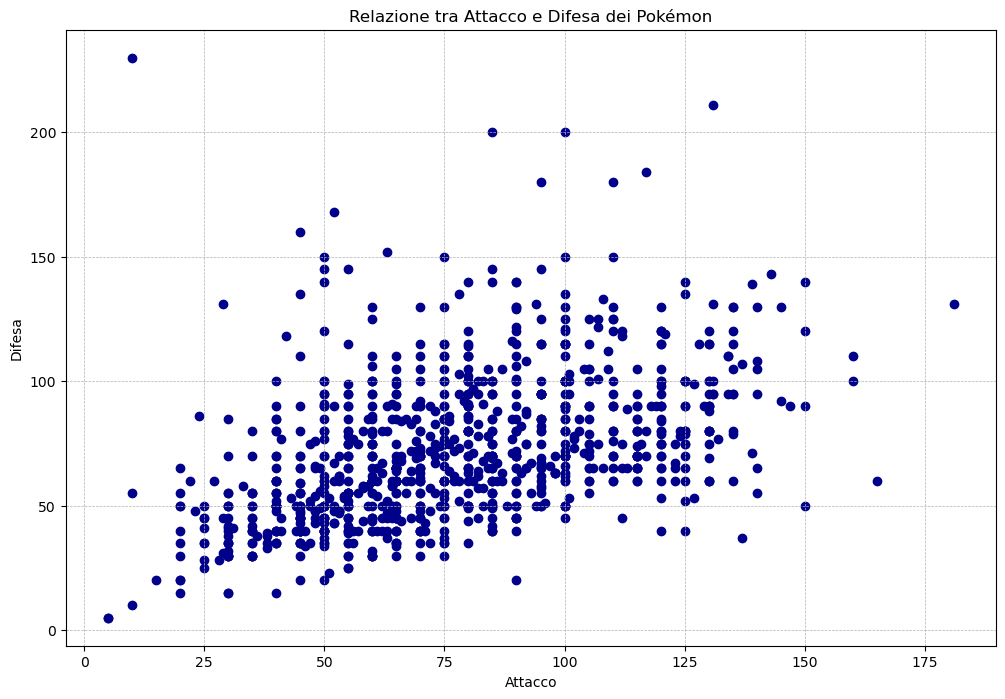

In [8]:
plt.figure(figsize=(12, 8))
plt.scatter(df['atk'], df['def'], c='darkblue')
plt.title('Relazione tra Attacco e Difesa dei Pokémon')
plt.xlabel('Attacco')
plt.ylabel('Difesa')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

RAPPORTO FRA HP E DIFESA

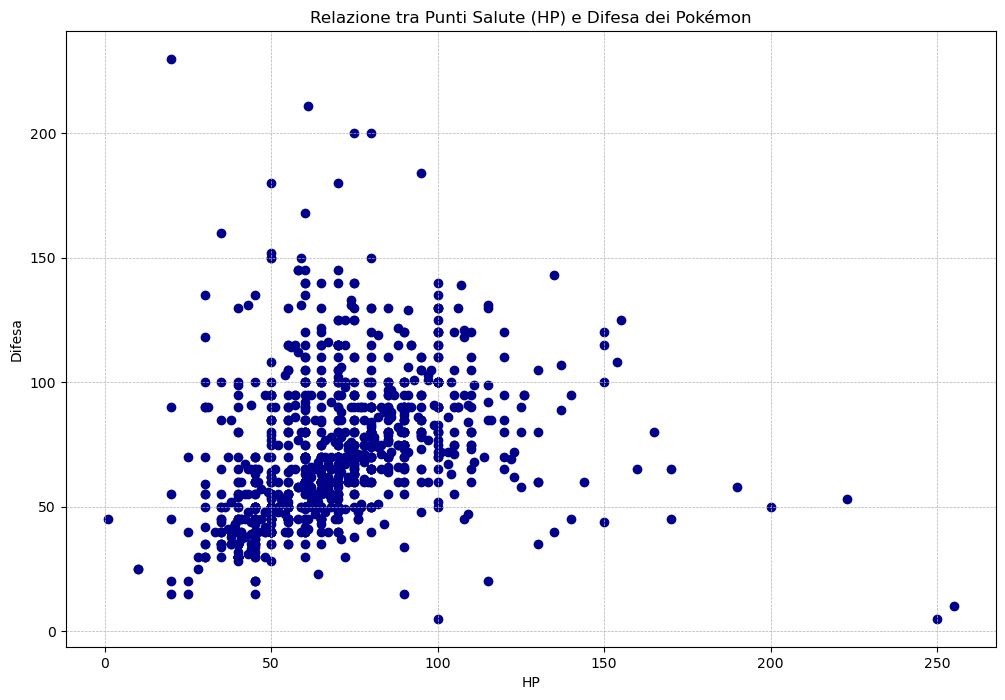

In [10]:
plt.figure(figsize=(12, 8))
plt.scatter(df['hp'], df['def'], c='darkblue')
plt.title('Relazione tra Punti Salute (HP) e Difesa dei Pokémon')
plt.xlabel('HP')
plt.ylabel('Difesa')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

STATISTICHE PER GENERAZIONI

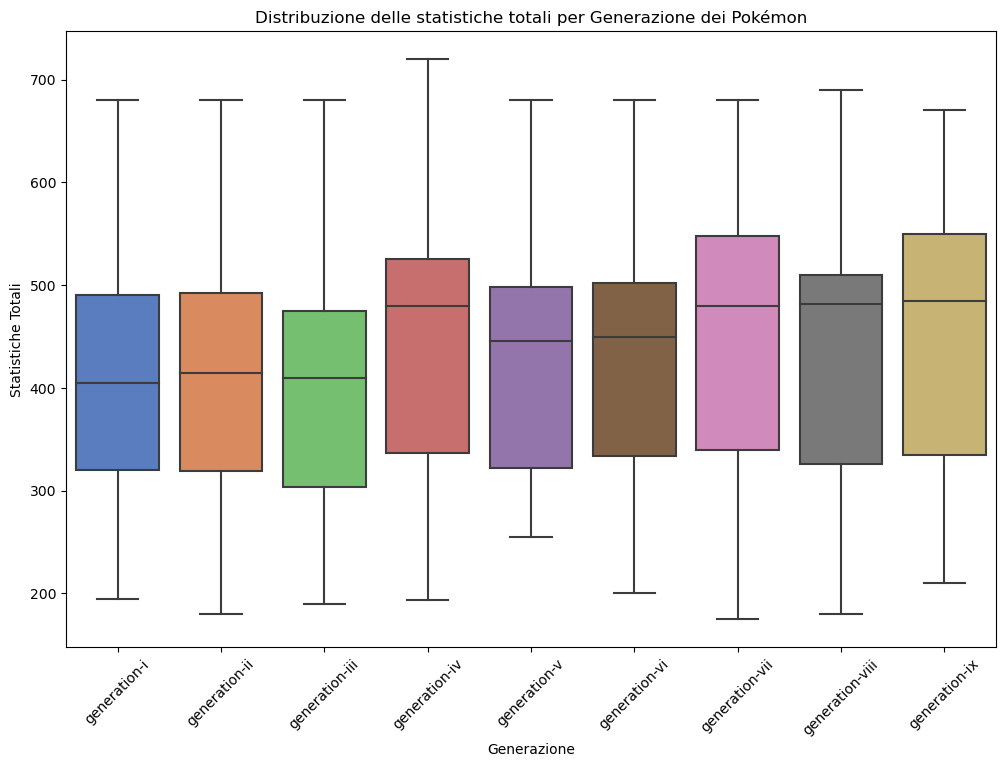

In [11]:
# Imposta le dimensioni del grafico.
plt.figure(figsize=(12, 8))

# 'palette' 'muted' utilizza una gamma di colori meno saturi per una visualizzazione più sobria.
sns.boxplot(x='generation', y='total', data=df, palette='muted')

# Imposta il titolo del grafico.
plt.title('Distribuzione delle statistiche totali per Generazione dei Pokémon')

# Imposta le etichette degli assi.
plt.xlabel('Generazione')
plt.ylabel('Statistiche Totali')

# Ruota le etichette sull'asse X di 45 gradi per migliorare la leggibilità.
plt.xticks(rotation=45)

# Mostra il grafico.
plt.show()

# MODELLO SVM #

In [14]:
# Convertiamo 'rank' in una variabile binaria per comodita (1 = leggendario, 0 = non leggendario)
pokemons['is_legendary'] = pokemons['rank'].apply(lambda x: 1 if x == 'legendary' else 0)

# Selezioniamo le caratteristiche (X) e l'etichetta (y)
X = pokemons[['hp', 'atk', 'def', 'spatk', 'spdef', 'speed']]
y = pokemons['is_legendary']

# Standardizziamo le caratteristiche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creiamo il modello SVM
model = SVC(kernel='linear', random_state=42)

# Configuriamo k-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Definiamo le metriche di performance da calcolare
metrics = ['accuracy', 'precision', 'recall', 'f1']
scores = {}

# Eseguiamo il k-fold cross validation per ogni metrica
for metric in metrics:
    score = cross_val_score(model, X_scaled, y, cv=kf, scoring=metric)
    scores[metric] = score.mean()

# Addestriamo il modello su tutto il dataset
model.fit(X_scaled, y)

# Stampiamo le medie delle prestazioni ottenute
print(f"Media Accuratezza: {scores['accuracy']*100:.2f}%")
print(f"Media Precision: {scores['precision']*100:.2f}%")
print(f"Media Recall: {scores['recall']*100:.2f}%")
print(f"Media F1 Score: {scores['f1']*100:.2f}%")

# Funzione per effettuare una previsione basata sul nome di un Pokémon
def predict_legendary_status_by_name(pokemon_name):
    pokemon_data = pokemons.loc[pokemons['name'].str.lower() == pokemon_name.lower(), ['hp', 'atk', 'def', 'spatk', 'spdef', 'speed']]
    
    if pokemon_data.empty:
        print("Pokémon non trovato.")
        return
    
    pokemon_stats_scaled = scaler.transform(pokemon_data)
    prediction = model.predict(pokemon_stats_scaled)
    
    if prediction == 1:
        print(f"{pokemon_name.title()} è previsto essere un Pokémon leggendario.")
    else:
        print(f"{pokemon_name.title()} non è previsto essere un Pokémon leggendario.")

# Ora il modello è pronto per predire lo status leggendario di un Pokémon dato il suo nome
pokemon_name = input("Inserisci il nome di un Pokémon per scoprire se è previsto essere leggendario: ")
predict_legendary_status_by_name(pokemon_name)

Media Accuratezza: 94.69%
Media Precision: 77.14%
Media Recall: 32.08%
Media F1 Score: 44.73%
Inserisci il nome di un Pokémon per scoprire se è previsto essere leggendario: Rayquaza
Rayquaza è previsto essere un Pokémon leggendario.


In [15]:
# Selezione delle caratteristiche (X) e della variabile target (y) per il training dei modelli.
X = pokemons[['hp', 'atk', 'def', 'spatk', 'spdef', 'speed']]  # Caratteristiche predittive
y = pokemons['is_legendary']  # Target binario

# Standardizzazione delle caratteristiche per avere media 0 e varianza 1.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Inizializzazione di vari modelli di machine learning con configurazioni specifiche.
models = {
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Configurazione della cross-validation a 5 fold.
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Valutazione delle prestazioni dei modelli attraverso la cross-validation.
results = {}
for name, model in models.items():
    # Esecuzione di predizioni tramite cross-validation per ogni modello.
    # 'cross_val_predict' restituisce le etichette predette per ogni parte del dataset quando è il suo turno di essere il set di test.
    y_pred = cross_val_predict(model, X_scaled, y, cv=kf)
    
    # Calcolo delle probabilità predette per le classi (usato per ROC AUC, Log Loss).
    y_pred_proba = cross_val_predict(model, X_scaled, y, cv=kf, method='predict_proba')[:, 1]
    
    # Calcolo delle diverse metriche di valutazione per ogni modello utilizzando le etichette e probabilità predette.
    results[name] = {
        'Accuracy': accuracy_score(y, y_pred),  # Quanto frequentemente il modello predice correttamente.
        'Precision': precision_score(y, y_pred),  # Proporzione di identificazioni positive che erano corrette.
        'Recall': recall_score(y, y_pred),  # Proporzione di positivi reali che sono stati identificati correttamente.
        'F1 Score': f1_score(y, y_pred),  # Media armonica di Precision e Recall.
        'ROC AUC': roc_auc_score(y, y_pred_proba),  # Area sotto la curva ROC.
        'Log Loss': log_loss(y, y_pred_proba),  # Misura l'incertezza delle previsioni basata sulle probabilità.
        'MCC': matthews_corrcoef(y, y_pred)  # Coefficiente di correlazione di Matthews.
    }

for model, metrics in results.items():  
    # Itera sul dizionario 'results'. Per ogni coppia chiave-valore, 'model' contiene il nome del modello 
    # e 'metrics' contiene un dizionario delle metriche di valutazione calcolate per quel modello.

    print(f"Model: {model}")  
    # Stampa il nome del modello corrente. 'model' è la chiave del dizionario 'results', che rappresenta il nome del modello.

    for metric, value in metrics.items():  
        # Itera sul dizionario delle metriche di valutazione per il modello corrente. 'metric' è il nome della metrica
        # e 'value' è il valore numerico di quella metrica.

        print(f"{metric}: {value:.4f}")  
        # Stampa il nome della metrica e il suo valore formattato con 4 cifre decimali. 
        # Questo formato aiuta a standardizzare la presentazione dei risultati per una lettura più facile.

    print("\n")  
    # Stampa una linea vuota per separare i risultati dei diversi modelli, migliorando così la leggibilità dell'output.

Model: SVM
Accuracy: 0.9469
Precision: 0.7419
Recall: 0.3333
F1 Score: 0.4600
ROC AUC: 0.9358
Log Loss: 0.1430
MCC: 0.4753


Model: Random Forest
Accuracy: 0.9518
Precision: 0.7941
Recall: 0.3913
F1 Score: 0.5243
ROC AUC: 0.9408
Log Loss: 0.1584
MCC: 0.5371


Model: Logistic Regression
Accuracy: 0.9469
Precision: 0.7419
Recall: 0.3333
F1 Score: 0.4600
ROC AUC: 0.9418
Log Loss: 0.1310
MCC: 0.4753


Model: K-Nearest Neighbors
Accuracy: 0.9430
Precision: 0.6222
Recall: 0.4058
F1 Score: 0.4912
ROC AUC: 0.8675
Log Loss: 0.5780
MCC: 0.4743


Model: Decision Tree
Accuracy: 0.9164
Precision: 0.3974
Recall: 0.4493
F1 Score: 0.4218
ROC AUC: 0.6998
Log Loss: 3.0125
MCC: 0.3777


